In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221029_btc_one_nn_avg'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2021-07-07 11:00:00+00:00,ADAUSDT,1.4206,1.4330,1.4170,1.4300,14548171.0,2.077201e+07,43515.0,7770863.0,...,1.427578,1.428275,0.003467,0.001119,1.428347,1.426760,0.000923,-0.000663,0.001112,0.000002
1,2021-06-20 11:00:00+00:00,ADAUSDT,1.3476,1.3533,1.3260,1.3293,38181143.0,5.110403e+07,87818.0,18535250.0,...,1.338757,1.337625,0.006228,0.003071,1.341067,1.336997,0.001983,-0.002087,0.003039,0.000011
2,2021-06-19 23:00:00+00:00,ADAUSDT,1.3910,1.4018,1.3821,1.3829,15747336.0,2.191540e+07,54828.0,7464234.0,...,1.391135,1.391458,0.004761,0.001728,1.392305,1.390117,0.001062,-0.001127,0.001573,0.000003
3,2021-06-25 09:00:00+00:00,ADAUSDT,1.3398,1.3570,1.3230,1.3289,37778606.0,5.060536e+07,79282.0,19752438.0,...,1.340072,1.341042,0.009537,0.002410,1.342172,1.338507,0.001910,-0.001755,0.002736,0.000009
4,2021-06-11 12:00:00+00:00,ADAUSDT,1.5176,1.5199,1.5039,1.5108,16425309.0,2.482271e+07,61590.0,7741869.0,...,1.511205,1.511150,0.002715,0.001816,1.512712,1.510028,0.001377,-0.001307,0.001776,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241655,2022-01-06 01:00:00+00:00,MATICUSDT,2.2040,2.2090,2.1450,2.1658,13881959.0,3.026007e+07,48277.0,6040660.0,...,2.183553,2.182717,0.012705,0.004017,2.186607,2.180752,0.002413,-0.003441,0.002683,0.000008
241656,2022-01-02 22:00:00+00:00,MATICUSDT,2.5123,2.5345,2.5113,2.5303,4489515.0,1.133739e+07,23375.0,2343854.0,...,2.526055,2.526575,0.004697,0.001549,2.526978,2.524592,0.001218,-0.001168,0.000945,0.000001
241657,2022-01-06 22:00:00+00:00,MATICUSDT,2.2289,2.2671,2.2195,2.2666,6409873.0,1.435081e+07,28441.0,3350752.0,...,2.240022,2.240467,0.010433,0.003247,2.241735,2.237627,0.002330,-0.001778,0.001836,0.000004
241658,2022-01-08 03:00:00+00:00,MATICUSDT,2.0915,2.0991,2.0716,2.0905,6062434.0,1.264769e+07,25121.0,2769257.0,...,2.087220,2.087917,0.005760,0.002397,2.089287,2.085470,0.002032,-0.001785,0.001829,0.000004


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-22 06:00:00+00:00 ETH     1098.57000  1100.04000  1083.0100   
                          LINK       5.99100     6.01000     5.8390   
                          LTC       61.92000    62.27000    61.5100   
                          MATIC      0.79510     0.79680     0.7803   
                          XRP        0.35400     0.35550     0.3509   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-22 06:00:00+00:00 ETH     1084.8200  4.174374e+05  1092.853333   
                          LINK       5.8760  5.164573e+06     5.932417   
                          LTC       61.6600  3.594963e+05    61.800000   
                          MATIC      0.7830  3.529054e+07     0.789225   
                          XRP        0.3534  9.421572e+07     0.353442   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-22 06:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[420995 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6 * 4, 12 * 4, 24 * 4, 36 * 4, 48 * 4, 72 * 4, 96 * 4]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-22 07:27:23.636149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 07:27:23.775280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 07:27:23.775332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 07:27:23.804110: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 07:27:24.475651: W tensorflow/stream_executor/platform/de

In [6]:
# https://github.com/CyberZHG/keras-drop-connect/blob/master/LICENSE

from inspect import getfullargspec

class GaussianDropConnect(tf.keras.layers.Wrapper):
    def __init__(self, layer, rate=0.0, seed=None, **kwargs):
        super(GaussianDropConnect, self).__init__(layer, **kwargs)
        if isinstance(rate, dict):
            for name in list(rate.keys()):
                rate[name] = min(1., max(0., rate[name]))
        else:
            rate = min(1., max(0., rate))
        self.rate = rate
        self.seed = seed
        self.supports_masking = self.layer.supports_masking

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
        super(GaussianDropConnect, self).build()
        
        def dropped_weight(weight, drop_connect_rate):
            sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
            def _dropped_weight():
                return weight * tf.keras.backend.random_normal(
                    shape=tf.shape(weight),
                    mean=1.0,
                    stddev=sigma,
                    dtype=weight.dtype,
                    seed=self.seed
                )
                return dropped
            return _dropped_weight

        training = None
        
        weights = []
        for w in self.layer.trainable_weights:
            weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        self.layer.trainable_weights = weights
        
    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def compute_mask(self, inputs, mask=None):
        return self.layer.compute_mask(inputs, mask)

    def call(self, inputs, training=None, mask=None):
        def has_arg(fn, name):
            arg_spec = getfullargspec(fn)
            return name in arg_spec.args or name in arg_spec.kwonlyargs

        kwargs = {}
        if has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        if has_arg(self.layer.call, 'mask'):
            kwargs['mask'] = mask

#         def dropped_weight(weight, drop_connect_rate):
#             sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
#             def _dropped_weight():
#                 return weight * tf.keras.backend.random_normal(
#                     shape=tf.shape(weight),
#                     mean=1.0,
#                     stddev=sigma,
#                     dtype=weight.dtype,
#                     seed=self.seed
#                 )
#                 return dropped
#             return _dropped_weight

#         origins = self.layer.trainable_weights
        
#         # origins = {}
#         if isinstance(self.rate, dict):
#             for name, rate in self.rate.items():
#                 w = getattr(self.layer, name)
#                 if w in self.layer.trainable_weights:
#                     origins[name] = w
#                     if 0. < rate < 1.:
#                         setattr(self.layer, name, )
#         else:
#             weights = []
#             for w in self.layer.trainable_weights:
#                 weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
#             self.layer.set_weights(weights)
                    
# #             for name in dir(self.layer):
# #                 try:
# #                     w = getattr(self.layer, name)
# #                 except Exception as e:
# #                     continue
                
# #                 if w in self.layer.trainable_weights:
# #                     origins[name] = w
# #                     if 0. < self.rate < 1.:
# #                         setattr(self.layer, name, tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        outputs = self.layer.call(inputs, **kwargs)
        # for name, w in origins.items():
        #     setattr(self.layer, name, w)
        # self.layer.set_weights(origins)
        return outputs

    def get_config(self):
        config = {
            'rate': self.rate,
            'seed': self.seed,
        }
        base_config = super(GaussianDropConnect, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [8]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [9]:
class WeightShuffleCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 20:
            return
        
        weights = self.model.get_weights()
        for i in range(0, len(weights)):
        # for i in range(len(weights) // 2, len(weights)):
            w = weights[i]
            if False:
            # if len(w.shape) == 1:
                w[:] = 0.0
            else:
                # flatten shuffle
                w = np.random.permutation(w.flatten()).reshape(w.shape)
                # axis 0 shuffle
                # w = np.random.permutation(w)
                # axis 1 shuffle 
                # maybe overfit
                # if len(w.shape) == 2:
                #     w = np.random.permutation(w.T).T
                # else:
                #     w = np.random.permutation(w)
            weights[i] = w

        self.model.set_weights(weights)


In [10]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [11]:
# https://arxiv.org/pdf/2002.08253.pdf
class MarsConstraint(tf.keras.constraints.Constraint):
    def __init__(self, gamma):
        self.gamma = gamma
        self.initial_weight = None

    def __call__(self, w):
        w = w - self.initial_weight
        norms = tf.keras.backend.sum(tf.keras.backend.abs(w), axis=range(len(w.shape) - 1), keepdims=True)
        w *= (1.0 / tf.keras.backend.maximum(1.0, norms / self.gamma))
        w += self.initial_weight
        return w

    def get_config(self):
        return { "gamma": self.gamma }

In [12]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [13]:
class WeightMACallback(tf.keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs=None):
        if hasattr(self, '_prev_weights'):
            self.model.set_weights(self._prev_weights)

    def on_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        
        decay = 0.99
        
        avg_weights = []
        if not hasattr(self, '_sum_weights'):
            self._sum_weights = weights
            self._sum_count = 1
        else:
            self._sum_count += 1
            for i in range(len(weights)):
                # self._sum_weights[i] += weights[i]
                self._sum_weights[i] = self._sum_weights[i] * decay + weights[i] * (1 - decay)
                # avg_weights += [self._sum_weights[i] / self._sum_count]
            self._prev_weights = weights
            # self.model.set_weights(avg_weights)
            self.model.set_weights(self._sum_weights)
        

In [14]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [15]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict scriptscript
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            patience=10,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    # WeightMACallback(),
                    es,
                    # WeightLenCallback(),
                    # tb, # last
                ],
                batch_size=4096 * 8,
                # batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            keras_model = models[i][1].model_
            keras_model.optimizer.assign_average_vars(keras_model.variables)

            models[i][1] = SimpleKerasPredictor(keras_model)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    # act = 'elu'
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    
    def initializer(shape, dtype=None):
        p = 0.1
        dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
        # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
        # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
        w = initializers.HeNormal()(shape, dtype=dtype)
        # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
        # w = w ** 3 # 3 is good
        w /= tf.reduce_mean(w ** 2) ** 0.5
        print(shape)
        n_in, n_out = shape
        # w /= n_in ** 0.5
        # w /= n_out ** 0.5 # good
        
        # https://arxiv.org/pdf/1902.06853.pdf
        w /= n_in ** 0.5
        # w *= 1.3
        # w *= 0.9
        return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    # not bad
#     x = Dense(size ** 4, use_bias=True, 
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size, size, size))(x)
    
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    
    # good
#     reg_cnn = reg
#     # reg_cnn = regularizers.l2(1e-3 * size ** 2)
#     reg_cnn1 = DistanceL2(l2_dist)
#     cnn1 = Dense(size ** 3,
#              # activation='relu',
#              use_bias=True,
#              # use_bias=False, # bad ?
#              kernel_regularizer=reg, 
#              # kernel_regularizer=reg_cnn1,
#              # kernel_regularizer=reg_l1, 
#              bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#     )
#     x = cnn1(x)
#     # x = Dropout(0.9)(x)
#     x = Reshape((size, size, size))(x)
    
#     reg_cnn2 = DistanceL2(l2_dist)
#     cnn2 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn, 
#                # kernel_regularizer=reg_cnn2, 
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn2(x)
#     # x = Dropout(0.9)(x)
#     reg_cnn3 = DistanceL2(l2_dist)
#     cnn3 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn,
#                # kernel_regularizer=reg_cnn3,
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn3(x)
    # x = Dropout(0.9)(x)
    
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    # x = Flatten()(x)
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    
#     x = Dense(size ** 2, use_bias=True,
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size))(x)
    
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    # x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.5)(x)
    
    # x = MaxPooling1D(pool_size=4, strides=2)(x)
    # x = AveragePooling1D(pool_size=4, strides=2)(x)
    # x = Flatten()(x)
    
    # x = tf.keras.layers.GaussianNoise(0.5)(x)
    
    # size = 32
    size = 64
    # size = 128
    # size = 512
    # size = 1024
    reg1 = DistanceL2(l2_dist)
    # d1 = tfa.layers.NoisyDense(
    # d1 = Dense(
    #     256,
    #     # size,
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg1,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d1(x)
    # x = BatchNormalization()(x)
    # x = Concatenate()([x, inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    reg2 = DistanceL2(l2_dist)
    d2_inputs = x
    # d2 = tfa.layers.NoisyDense(
    # d2 = Dense(
    #     # 64, 
    #     128,
    #     # 512,
    #     # size, 
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg2,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d2(x)
    # x = Concatenate()([x, inputs, d2_inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    depth = 2 + idx * 0
    for i in range(depth):
        t = 1.0 * i / (depth - 1)
        x_prev = x
        
        dist_reg = DistanceL2(l2_dist)
        dist_regs.append(dist_reg)
        mars_constraint = MarsConstraint(8)
        mars_constraints.append(mars_constraint)
        # dense = GaussianDropConnectDense(
        dense = Dense(
            # size,
            # 32,
            # 64,
            128, # good with l2 reg
            # 256,
            # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
            # 64 if i == 0 else 128,
            activation=act, 
            # activation=None,
            use_bias=True,
            # use_bias=False,
            # kernel_regularizer=reg_l1, 
            kernel_regularizer=reg,
            # kernel_regularizer=dist_reg,
            # kernel_regularizer=reg2,
            bias_regularizer=reg,
            # kernel_initializer='zeros' if i > 0 else initializer,
            kernel_initializer=initializer, 
            bias_initializer=bias_initializer,
            # kernel_constraint=mars_constraint,
            # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
        )
        dist_reg_layers.append(dense)
        # dense = GaussianDropConnect(dense, rate=0.2)
        x = dense(x)
        # x = BatchNormalization()(x)
        # def smooth_units(x):
        #     return (x[:, 1:] + x[:, :-1]) / 2
        #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
        # x = Lambda(smooth_units)(x)
        # x = Activation(act)(x)
        # x = Lambda(smooth_units)(x)
        # if i > 0:
        #     x = Add()([x, x_prev])
        # if i == 9:
        #     x = tf.keras.layers.GaussianDropout(0.5)(x)
        # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
        # x = Dropout(dropout_rate)(x)
        # x = Dropout(0.1)(x)
        # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
        hidden_outputs.append(x)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
        # dense = GaussianDropConnectDense(
        # dense1 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense1)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         # dense = GaussianDropConnectDense(
#         dense2 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense2)
        
#         u = dense1(x)
#         v = dense2(x)
#         x = Concatenate()([Add()([u, v]), Subtract()([u, v])])
#         x = Rescaling(0.5 ** 0.5)(x)
#         x = Activation(act)(x)
        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1, 
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    # opt = Nadam(
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.002,
    #     beta_1=0.9, 
    #     # beta_1=0.5,
    #     # beta_2=0.9,
    #     beta_2=0.999,
    #     epsilon=None,
    #     # epsilon=1e-1,
    #     # epsilon=1e-3,
    #     schedule_decay=0.004,
    # )
    opt = tfa.optimizers.AdaBelief(
        # learning_rate=0.001,
        learning_rate=0.001 / 8,
        # learning_rate=0.001 / 8 / 8,
        # learning_rate=0.001 / 8 / 8 / 8,
        # total_steps=1200,
        # warmup_proportion=0.1,
        # min_lr=1e-5,
        # rectify=True,
        # weight_decay=1e-2,
        # weight_decay=1e-3,
        # epsilon=1e-10,
    )
    opt = tfa.optimizers.MovingAverage(opt)
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # 0.18 1.3 drop connect sigma 0.5 2e-4
    # 0.15 1.1 drop connect sigma 0.5 2e-4 es 40
    # 0.17 1.2 2e-4
    # todo 1e-4
    # 0.164 1.0 drop connect sigma 0.5 2e-3 
    # 0.135 1.0 2e-3
    # 0.17 1.1 2e-3 dist l2 1e-4
    # 0.170 1.35 2e-3 dist l2 0 elu
    # 0.182 1.44 2e-3 dist l2 0 elu mixout(weight)
    # 0.182 1.37 2e-4 dist l2 0 elu mixout(weight)
    # 0.191 1.52 2e-4(patient40) dist l2 0 elu mixout(weight) https://gist.github.com/richmanbtc/e3b7b480466e425ee12223e476b2643e
    # 0.165 1.14 adabelief dist l2 0 elu last layer zeros no output rescaling
    # 0.159 1.14 adabelief dist l2 0 elu last layer zeros
    # 0.182 1.24 adabelief dist l2 0 elu batch 512 lr 0.001 / 8
    # 0.173 1.32 adabelief dist l2 0 elu batch 64 lr 0.001 / 64
    # 0.172 1.47 adabelief dist l2 0 elu smooth
    # 0.169 1.41 adabelief dist l2 0 elu smooth unit 128
    # 0.161 1.24 adabelief dist l2 0 elu smooth unit 128 last pooling 2
    # 0.164 1.25 adabelief dist l2 0 elu smooth 4
    # 0.183 1.47 adabelief dist l2 0 elu mixout(weight, 0.5)
    # 0.180 1.36 adabelief dist l2 0 elu mixout(weight, 0.7)
    # 0.180 1.35 adabelief dist l2 0 elu mixout(weight, 0.3)
    # 0.176 1.46 adabelief dist l2 0 elu
    # 0.180 1.60 adabelief dist l2 0 elu output gaussian dropout 0.5 work1:https://gist.github.com/richmanbtc/da475809b4da464de864f661db7ab033
    # 0.183 1.61 adabelief dist l2 0 elu output dropout 0.5
    # 0.191 1.55 adabelief dist l2 0 elu output dropout 0.5 mixout(weight, 0.5)
    # 0.168 1.11 adabelief dist l2 0 elu no dropout
    # 0.159 1.28 adabelief dist l2 0 elu no dropout output l2 0.01
    # 0.187 1.57 2e-4 dist l2 0 elu output dropout 0.5
    # 0.178 1.40 adabelief dist l2 1e-4 elu
    # 0.163 1.27 adabelief dist l2 0 elu dropout 0.995 unit 128
    # 0.177 1.40 adabelief dist l2 0 elu unit 128 mixout(weight, 0.5)
    # 0.193 1.52 adabelief dist l2 0 elu mars 8 https://gist.github.com/richmanbtc/1a86fa1e40c5afad8de129373cabe372
    # 0.163 1.19 adabelief dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.185 1.47 2e-4 dist l2 0 elu mars 8
    # 0.185 1.37 2e-4 dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.180 1.38 2e-3 dist l2 0 elu gaussian mixout(weight)
    # 0.156 1.18 2e-3 dist l2 0 elu 6 layer
    # 0.150 1.09 2e-3 dist l2 0 relu 6 layer
    # 0.154 1.22 2e-3 dist l2 1e-4 relu 6 layer
    # 0.155 1.18 2e-3 dist l2 1e-4 elu 6 layer
    # 0.165 1.20 2e-3 dist l2 0 elu mixout(weight) 6 layer
    # 0.155 1.32 2e-3 dist l2 0 elu gaussian mixout(weight) 6 layer
    # 0.168 1.34 2e-3 dist l2 0 elu mixout(weight) 4 layer
    # 0.170 1.32 2e-3 dist l2 1e-4 elu
    # 0.175 1.31 2e-3 dist l2 1e-4 elu mixout(weight)
    # 0.185 1.37 2e-4 dist l2 1e-4 relu
    # 0.187 1.48 2e-4 dist l2 1e-4 elu https://gist.github.com/richmanbtc/0d4f571b5bc21b590934e4930b54a21e
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     # learning_rate=0.002,
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

print(tf.keras.backend.floatx())

float32


/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (340916, 731)


2022-11-22 07:31:48.773182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 07:31:48.773233: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 07:31:48.773256: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3976f2d8fcb9): /proc/driver/nvidia/version does not exist
2022-11-22 07:31:48.773458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
8/8 - 3s - loss: 1.0818 - mse: 1.0003 - weighted_mse: 0.9991 - cosine_similarity: 0.0473 - val_loss: 0.8088 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0186 - 3s/epoch - 415ms/step
Epoch 2/1000
8/8 - 1s - loss: 1.0816 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0572 - val_loss: 0.8087 - val_mse: 1.0003 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0242 - 1s/epoch - 127ms/step
Epoch 3/1000
8/8 - 1s - loss: 1.0808 - mse: 1.0003 - weighted_mse: 0.9982 - cosine_similarity: 0.0787 - val_loss: 0.8086 - val_mse: 1.0004 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0364 - 995ms/epoch - 124ms/step
Epoch 4/1000
8/8 - 1s - loss: 1.0798 - mse: 1.0003 - weighted_mse: 0.9972 - cosine_similarity: 0.0971 - val_loss: 0.8084 - val_mse: 1.0005 - val_weighted_mse: 0.9994 - val_cosine_similarity: 0.0448 - 1s/epoch - 125ms/step
Epoch 5/1000
8/8 - 1s - loss: 1.0784 - mse: 1.0003 - weighted_mse: 0.9959 - co

2022-11-22 07:47:57.863850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:47:57.863964: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:47:57.864850: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj66w18n5
2022-11-22 07:47:57.867026: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:47:57.867100: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj66w18n5
2022-11-22 07:47:57.872901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-22 07:47:57.874415: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:47:57.938364: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj66w18n5
2022-11

INFO:tensorflow:Assets written to: /tmp/tmput712i4b/assets


INFO:tensorflow:Assets written to: /tmp/tmput712i4b/assets
2022-11-22 07:47:59.304729: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:47:59.304835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:47:59.305022: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmput712i4b
2022-11-22 07:47:59.306881: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:47:59.306904: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmput712i4b
2022-11-22 07:47:59.312304: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:47:59.376740: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmput712i4b
2022-11-22 07:47:59.390560: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8k60_98r/assets


INFO:tensorflow:Assets written to: /tmp/tmp8k60_98r/assets
2022-11-22 07:48:00.698823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:00.698904: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:00.699088: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8k60_98r
2022-11-22 07:48:00.700852: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:00.700873: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8k60_98r
2022-11-22 07:48:00.706110: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:00.770361: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8k60_98r
2022-11-22 07:48:00.783187: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfac3rxhs/assets


INFO:tensorflow:Assets written to: /tmp/tmpfac3rxhs/assets
2022-11-22 07:48:02.155241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:02.155327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:02.155519: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfac3rxhs
2022-11-22 07:48:02.157322: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:02.157347: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfac3rxhs
2022-11-22 07:48:02.162689: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:02.227410: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfac3rxhs
2022-11-22 07:48:02.241062: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2_80jrje/assets


INFO:tensorflow:Assets written to: /tmp/tmp2_80jrje/assets
2022-11-22 07:48:03.628863: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:03.628947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:03.629133: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2_80jrje
2022-11-22 07:48:03.631129: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:03.631153: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2_80jrje
2022-11-22 07:48:03.639356: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:03.705557: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2_80jrje
2022-11-22 07:48:03.718549: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpeixh9ufc/assets


INFO:tensorflow:Assets written to: /tmp/tmpeixh9ufc/assets
2022-11-22 07:48:05.093642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:05.093717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:05.093905: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpeixh9ufc
2022-11-22 07:48:05.095820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:05.095844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpeixh9ufc
2022-11-22 07:48:05.101354: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:05.165180: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpeixh9ufc
2022-11-22 07:48:05.178657: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5sb87_rv/assets


INFO:tensorflow:Assets written to: /tmp/tmp5sb87_rv/assets
2022-11-22 07:48:06.530923: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:06.531017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:06.531203: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5sb87_rv
2022-11-22 07:48:06.532982: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:06.533003: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5sb87_rv
2022-11-22 07:48:06.538329: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:06.602138: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5sb87_rv
2022-11-22 07:48:06.616122: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6p7jmnxh/assets


INFO:tensorflow:Assets written to: /tmp/tmp6p7jmnxh/assets
2022-11-22 07:48:07.978740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:07.978836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:07.979027: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6p7jmnxh
2022-11-22 07:48:07.980878: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:07.980916: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6p7jmnxh
2022-11-22 07:48:07.986283: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:08.051930: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6p7jmnxh
2022-11-22 07:48:08.066113: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwd9lw1yx/assets


INFO:tensorflow:Assets written to: /tmp/tmpwd9lw1yx/assets
2022-11-22 07:48:09.395500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:09.395593: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:09.395789: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwd9lw1yx
2022-11-22 07:48:09.397613: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:09.397649: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwd9lw1yx
2022-11-22 07:48:09.403144: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:09.468679: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwd9lw1yx
2022-11-22 07:48:09.482248: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkier031s/assets


INFO:tensorflow:Assets written to: /tmp/tmpkier031s/assets
2022-11-22 07:48:10.812263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:48:10.812339: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:48:10.812525: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkier031s
2022-11-22 07:48:10.814305: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:48:10.814330: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkier031s
2022-11-22 07:48:10.819512: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:48:10.881574: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkier031s
2022-11-22 07:48:10.895358: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

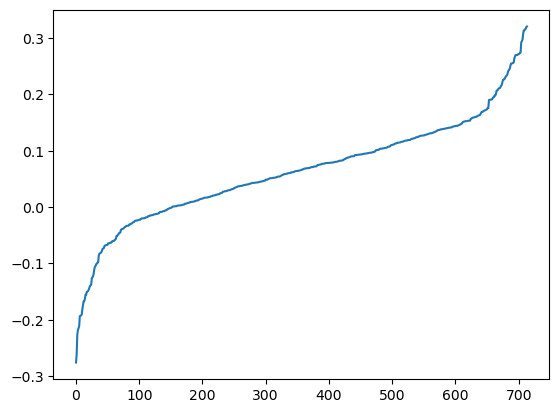

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (307501, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
7/7 - 3s - loss: 1.0854 - mse: 1.0002 - weighted_mse: 0.9986 - cosine_similarity: 0.0591 - val_loss: 0.7996 - val_mse: 1.0003 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0054 - 3s/epoch - 447ms/step
Epoch 2/1000
7/7 - 1s - loss: 1.0852 - mse: 1.0002 - weighted_mse: 0.9984 - cosine_similarity: 0.0661 - val_loss: 0.7995 - val_mse: 1.0004 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0106 - 920ms/epoch - 131ms/step
Epoch 3/1000
7/7 - 1s - loss: 1.0847 - mse: 1.0002 - weighted_mse: 0.9980 - cosine_similarity: 0.0783 - val_loss: 0.7995 - val_mse: 1.0005 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0165 - 910ms/epoch - 130ms/step
Epoch 4/1000
7/7 - 1s - loss: 1.0840 - mse: 1.0003 - weighted_mse: 0.9973 - cosine_similarity: 0.0929 - val_loss: 0.7994 - val_mse: 1.0006 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0258 - 908ms/epoch - 130ms/step
Epoch 5/1000
7/7 - 1s - loss: 1.0830 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmp8xnzhzx4/assets
2022-11-22 08:06:18.701907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:18.701992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:18.702184: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8xnzhzx4
2022-11-22 08:06:18.703937: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:18.703958: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8xnzhzx4
2022-11-22 08:06:18.709708: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:18.772118: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8xnzhzx4
2022-11-22 08:06:18.786034: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5wm62nim/assets


INFO:tensorflow:Assets written to: /tmp/tmp5wm62nim/assets
2022-11-22 08:06:20.124687: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:20.124769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:20.124995: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5wm62nim
2022-11-22 08:06:20.126770: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:20.126798: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5wm62nim
2022-11-22 08:06:20.132116: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:20.196925: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5wm62nim
2022-11-22 08:06:20.209952: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp36fo0_bg/assets


INFO:tensorflow:Assets written to: /tmp/tmp36fo0_bg/assets
2022-11-22 08:06:21.532878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:21.532961: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:21.533152: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp36fo0_bg
2022-11-22 08:06:21.534891: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:21.534912: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp36fo0_bg
2022-11-22 08:06:21.540326: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:21.602851: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp36fo0_bg
2022-11-22 08:06:21.615669: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk7vqxz_q/assets


INFO:tensorflow:Assets written to: /tmp/tmpk7vqxz_q/assets
2022-11-22 08:06:22.960489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:22.960570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:22.960762: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk7vqxz_q
2022-11-22 08:06:22.962645: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:22.962681: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk7vqxz_q
2022-11-22 08:06:22.968201: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:23.034488: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk7vqxz_q
2022-11-22 08:06:23.049158: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6f8irnej/assets


INFO:tensorflow:Assets written to: /tmp/tmp6f8irnej/assets
2022-11-22 08:06:24.397512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:24.397595: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:24.397791: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6f8irnej
2022-11-22 08:06:24.399538: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:24.399560: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6f8irnej
2022-11-22 08:06:24.404860: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:24.478066: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6f8irnej
2022-11-22 08:06:24.491927: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa7mi7xe5/assets


INFO:tensorflow:Assets written to: /tmp/tmpa7mi7xe5/assets
2022-11-22 08:06:25.822167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:25.822252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:25.822438: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa7mi7xe5
2022-11-22 08:06:25.824204: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:25.824226: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa7mi7xe5
2022-11-22 08:06:25.830594: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:25.894301: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa7mi7xe5
2022-11-22 08:06:25.907051: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpur3z6b55/assets


INFO:tensorflow:Assets written to: /tmp/tmpur3z6b55/assets
2022-11-22 08:06:27.255775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:27.255868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:27.256066: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpur3z6b55
2022-11-22 08:06:27.257854: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:27.257877: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpur3z6b55
2022-11-22 08:06:27.263382: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:27.327081: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpur3z6b55
2022-11-22 08:06:27.340748: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp90rr70f0/assets


INFO:tensorflow:Assets written to: /tmp/tmp90rr70f0/assets
2022-11-22 08:06:28.695366: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:28.695453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:28.695638: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp90rr70f0
2022-11-22 08:06:28.697443: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:28.697467: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp90rr70f0
2022-11-22 08:06:28.702778: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:28.767679: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp90rr70f0
2022-11-22 08:06:28.780980: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpevndf4kl/assets


INFO:tensorflow:Assets written to: /tmp/tmpevndf4kl/assets
2022-11-22 08:06:30.116314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:30.116396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:30.116586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpevndf4kl
2022-11-22 08:06:30.118369: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:30.118393: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpevndf4kl
2022-11-22 08:06:30.124636: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:30.189105: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpevndf4kl
2022-11-22 08:06:30.202274: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1gd52p5s/assets


INFO:tensorflow:Assets written to: /tmp/tmp1gd52p5s/assets
2022-11-22 08:06:31.527720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:06:31.527804: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:06:31.527999: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1gd52p5s
2022-11-22 08:06:31.529771: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:06:31.529796: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1gd52p5s
2022-11-22 08:06:31.535111: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:06:31.599573: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1gd52p5s
2022-11-22 08:06:31.612499: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

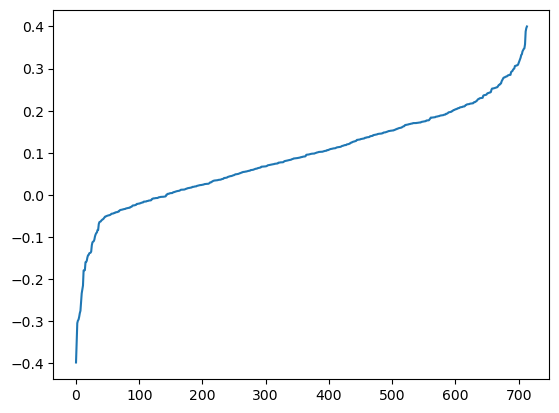

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (283904, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
7/7 - 3s - loss: 1.1319 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0660 - val_loss: 0.6910 - val_mse: 1.0003 - val_weighted_mse: 0.9999 - val_cosine_similarity: 0.0163 - 3s/epoch - 431ms/step
Epoch 2/1000
7/7 - 1s - loss: 1.1317 - mse: 1.0002 - weighted_mse: 0.9984 - cosine_similarity: 0.0727 - val_loss: 0.6909 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0189 - 854ms/epoch - 122ms/step
Epoch 3/1000
7/7 - 1s - loss: 1.1311 - mse: 1.0002 - weighted_mse: 0.9979 - cosine_similarity: 0.0856 - val_loss: 0.6909 - val_mse: 1.0004 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0259 - 856ms/epoch - 122ms/step
Epoch 4/1000
7/7 - 1s - loss: 1.1302 - mse: 1.0002 - weighted_mse: 0.9971 - cosine_similarity: 0.1012 - val_loss: 0.6908 - val_mse: 1.0005 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0304 - 852ms/epoch - 122ms/step
Epoch 5/1000
7/7 - 1s - loss: 1.1291 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmpsxuyc9or/assets
2022-11-22 08:29:48.746980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:48.747089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:48.747431: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsxuyc9or
2022-11-22 08:29:48.749448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:48.749485: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsxuyc9or
2022-11-22 08:29:48.755006: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:48.821419: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsxuyc9or
2022-11-22 08:29:48.834852: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsczufj7j/assets


INFO:tensorflow:Assets written to: /tmp/tmpsczufj7j/assets
2022-11-22 08:29:50.185484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:50.185565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:50.185757: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsczufj7j
2022-11-22 08:29:50.187558: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:50.187586: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsczufj7j
2022-11-22 08:29:50.193282: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:50.261159: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsczufj7j
2022-11-22 08:29:50.275203: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1axhioq5/assets


INFO:tensorflow:Assets written to: /tmp/tmp1axhioq5/assets
2022-11-22 08:29:51.634484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:51.634569: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:51.634762: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1axhioq5
2022-11-22 08:29:51.636575: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:51.636601: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1axhioq5
2022-11-22 08:29:51.641999: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:51.706222: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1axhioq5
2022-11-22 08:29:51.720536: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpywcvo75e/assets


INFO:tensorflow:Assets written to: /tmp/tmpywcvo75e/assets
2022-11-22 08:29:53.059734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:53.059824: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:53.060016: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpywcvo75e
2022-11-22 08:29:53.061800: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:53.061823: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpywcvo75e
2022-11-22 08:29:53.067148: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:53.131725: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpywcvo75e
2022-11-22 08:29:53.146754: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyye74o59/assets


INFO:tensorflow:Assets written to: /tmp/tmpyye74o59/assets
2022-11-22 08:29:54.476408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:54.476504: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:54.476699: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyye74o59
2022-11-22 08:29:54.478525: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:54.478556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyye74o59
2022-11-22 08:29:54.483846: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:54.549733: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyye74o59
2022-11-22 08:29:54.563359: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5mx1bt3w/assets


INFO:tensorflow:Assets written to: /tmp/tmp5mx1bt3w/assets
2022-11-22 08:29:55.895737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:55.895818: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:55.896010: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5mx1bt3w
2022-11-22 08:29:55.897819: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:55.897842: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5mx1bt3w
2022-11-22 08:29:55.903059: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:55.966113: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5mx1bt3w
2022-11-22 08:29:55.979565: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8hc71dml/assets


INFO:tensorflow:Assets written to: /tmp/tmp8hc71dml/assets
2022-11-22 08:29:57.304996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:57.305077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:57.305268: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8hc71dml
2022-11-22 08:29:57.307027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:57.307049: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8hc71dml
2022-11-22 08:29:57.312352: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:57.375199: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8hc71dml
2022-11-22 08:29:57.389021: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpux4kudq_/assets


INFO:tensorflow:Assets written to: /tmp/tmpux4kudq_/assets
2022-11-22 08:29:58.706777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:29:58.706864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:29:58.707063: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpux4kudq_
2022-11-22 08:29:58.708853: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:29:58.708878: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpux4kudq_
2022-11-22 08:29:58.714428: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:29:58.777917: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpux4kudq_
2022-11-22 08:29:58.791215: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4iau2ahe/assets


INFO:tensorflow:Assets written to: /tmp/tmp4iau2ahe/assets
2022-11-22 08:30:00.121344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:30:00.121430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:30:00.121622: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4iau2ahe
2022-11-22 08:30:00.123398: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:30:00.123426: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4iau2ahe
2022-11-22 08:30:00.128909: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:30:00.191887: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4iau2ahe
2022-11-22 08:30:00.205274: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdbbr1k2n/assets


INFO:tensorflow:Assets written to: /tmp/tmpdbbr1k2n/assets
2022-11-22 08:30:01.553419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:30:01.553502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:30:01.553701: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdbbr1k2n
2022-11-22 08:30:01.555481: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:30:01.555518: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdbbr1k2n
2022-11-22 08:30:01.560944: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:30:01.624907: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdbbr1k2n
2022-11-22 08:30:01.638660: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

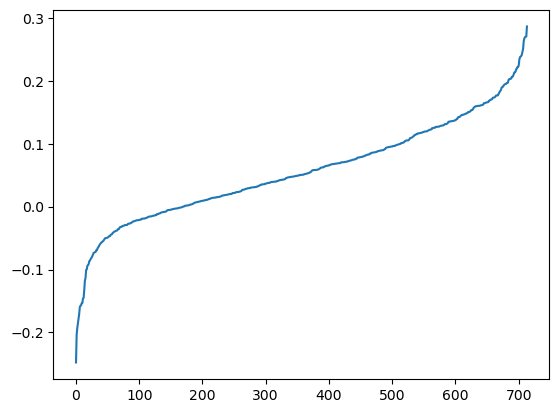

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (244756, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
6/6 - 3s - loss: 1.1222 - mse: 1.0002 - weighted_mse: 0.9985 - cosine_similarity: 0.0571 - val_loss: 0.7139 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0212 - 3s/epoch - 487ms/step
Epoch 2/1000
6/6 - 1s - loss: 1.1220 - mse: 1.0002 - weighted_mse: 0.9984 - cosine_similarity: 0.0605 - val_loss: 0.7139 - val_mse: 1.0003 - val_weighted_mse: 0.9998 - val_cosine_similarity: 0.0239 - 739ms/epoch - 123ms/step
Epoch 3/1000
6/6 - 1s - loss: 1.1216 - mse: 1.0002 - weighted_mse: 0.9980 - cosine_similarity: 0.0719 - val_loss: 0.7139 - val_mse: 1.0003 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0265 - 734ms/epoch - 122ms/step
Epoch 4/1000
6/6 - 1s - loss: 1.1209 - mse: 1.0002 - weighted_mse: 0.9974 - cosine_similarity: 0.0863 - val_loss: 0.7138 - val_mse: 1.0004 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0305 - 745ms/epoch - 124ms/step
Epoch 5/1000
6/6 - 1s - loss: 1.1200 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmpuyq1whi0/assets
2022-11-22 08:42:38.957421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:38.957509: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:38.957706: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuyq1whi0
2022-11-22 08:42:38.959663: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:38.959687: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuyq1whi0
2022-11-22 08:42:38.965179: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:39.029054: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuyq1whi0
2022-11-22 08:42:39.043674: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp20k5ju4e/assets


INFO:tensorflow:Assets written to: /tmp/tmp20k5ju4e/assets
2022-11-22 08:42:40.335838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:40.335927: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:40.336117: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp20k5ju4e
2022-11-22 08:42:40.337940: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:40.337963: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp20k5ju4e
2022-11-22 08:42:40.343224: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:40.404834: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp20k5ju4e
2022-11-22 08:42:40.417293: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3qinfwax/assets


INFO:tensorflow:Assets written to: /tmp/tmp3qinfwax/assets
2022-11-22 08:42:41.748947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:41.749042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:41.749242: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3qinfwax
2022-11-22 08:42:41.751100: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:41.751129: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3qinfwax
2022-11-22 08:42:41.756813: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:41.821643: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3qinfwax
2022-11-22 08:42:41.834855: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp36te6c35/assets


INFO:tensorflow:Assets written to: /tmp/tmp36te6c35/assets
2022-11-22 08:42:43.168670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:43.168750: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:43.168963: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp36te6c35
2022-11-22 08:42:43.170756: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:43.170779: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp36te6c35
2022-11-22 08:42:43.176176: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:43.243334: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp36te6c35
2022-11-22 08:42:43.256910: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1tp3c0vr/assets


INFO:tensorflow:Assets written to: /tmp/tmp1tp3c0vr/assets
2022-11-22 08:42:44.589757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:44.589838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:44.590029: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1tp3c0vr
2022-11-22 08:42:44.591804: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:44.591827: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1tp3c0vr
2022-11-22 08:42:44.597109: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:44.659963: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1tp3c0vr
2022-11-22 08:42:44.672595: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplmoo67ct/assets


INFO:tensorflow:Assets written to: /tmp/tmplmoo67ct/assets
2022-11-22 08:42:45.999658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:45.999748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:45.999940: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplmoo67ct
2022-11-22 08:42:46.001745: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:46.001771: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplmoo67ct
2022-11-22 08:42:46.007147: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:46.071445: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplmoo67ct
2022-11-22 08:42:46.084413: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnnnlycue/assets


INFO:tensorflow:Assets written to: /tmp/tmpnnnlycue/assets
2022-11-22 08:42:47.445362: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:47.445446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:47.445640: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnnnlycue
2022-11-22 08:42:47.447439: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:47.447469: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnnnlycue
2022-11-22 08:42:47.452909: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:47.517346: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnnnlycue
2022-11-22 08:42:47.530393: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmped8yjmm5/assets


INFO:tensorflow:Assets written to: /tmp/tmped8yjmm5/assets
2022-11-22 08:42:48.906889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:48.906968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:48.907168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmped8yjmm5
2022-11-22 08:42:48.908969: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:48.909005: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmped8yjmm5
2022-11-22 08:42:48.914772: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:48.983893: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmped8yjmm5
2022-11-22 08:42:48.997725: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxkoaz53t/assets


INFO:tensorflow:Assets written to: /tmp/tmpxkoaz53t/assets
2022-11-22 08:42:50.346224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:50.346318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:50.346513: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxkoaz53t
2022-11-22 08:42:50.348302: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:50.348327: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxkoaz53t
2022-11-22 08:42:50.353844: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:50.418741: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxkoaz53t
2022-11-22 08:42:50.432172: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp920on2fb/assets


INFO:tensorflow:Assets written to: /tmp/tmp920on2fb/assets
2022-11-22 08:42:51.766391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:42:51.766470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:42:51.766661: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp920on2fb
2022-11-22 08:42:51.768426: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:42:51.768449: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp920on2fb
2022-11-22 08:42:51.773722: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:42:51.836281: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp920on2fb
2022-11-22 08:42:51.849725: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

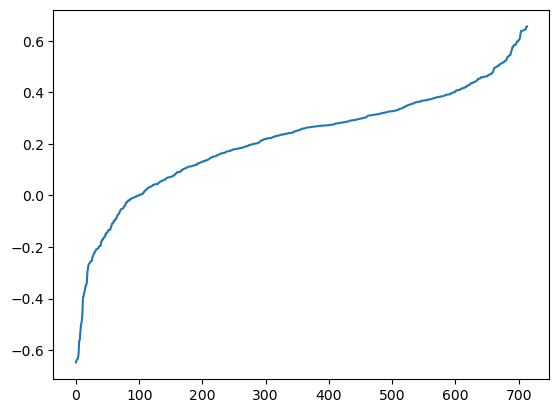

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (226471, 731)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
5/5 - 3s - loss: 0.9865 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0458 - val_loss: 1.0283 - val_mse: 1.0001 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0466 - 3s/epoch - 572ms/step
Epoch 2/1000
5/5 - 1s - loss: 0.9865 - mse: 1.0003 - weighted_mse: 0.9988 - cosine_similarity: 0.0487 - val_loss: 1.0282 - val_mse: 1.0001 - val_weighted_mse: 0.9995 - val_cosine_similarity: 0.0562 - 721ms/epoch - 144ms/step
Epoch 3/1000
5/5 - 1s - loss: 0.9862 - mse: 1.0003 - weighted_mse: 0.9985 - cosine_similarity: 0.0567 - val_loss: 1.0281 - val_mse: 1.0001 - val_weighted_mse: 0.9994 - val_cosine_similarity: 0.0657 - 712ms/epoch - 142ms/step
Epoch 4/1000
5/5 - 1s - loss: 0.9858 - mse: 1.0003 - weighted_mse: 0.9981 - cosine_similarity: 0.0653 - val_loss: 1.0279 - val_mse: 1.0002 - val_weighted_mse: 0.9992 - val_cosine_similarity: 0.0760 - 697ms/epoch - 139ms/step
Epoch 5/1000
5/5 - 1s - loss: 0.9852 - mse: 1

INFO:tensorflow:Assets written to: /tmp/tmpwyizgnwf/assets
2022-11-22 08:57:48.594580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:48.594677: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:48.594871: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwyizgnwf
2022-11-22 08:57:48.596725: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:48.596748: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwyizgnwf
2022-11-22 08:57:48.602080: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:48.665871: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwyizgnwf
2022-11-22 08:57:48.681305: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphg0cxyi5/assets


INFO:tensorflow:Assets written to: /tmp/tmphg0cxyi5/assets
2022-11-22 08:57:49.983365: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:49.983452: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:49.983640: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphg0cxyi5
2022-11-22 08:57:49.985478: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:49.985502: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphg0cxyi5
2022-11-22 08:57:49.990873: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:50.054701: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphg0cxyi5
2022-11-22 08:57:50.068521: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxkh64uxc/assets


INFO:tensorflow:Assets written to: /tmp/tmpxkh64uxc/assets
2022-11-22 08:57:52.608367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:52.608457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:52.608652: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxkh64uxc
2022-11-22 08:57:52.611041: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:52.611070: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxkh64uxc
2022-11-22 08:57:52.618220: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:52.690890: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxkh64uxc
2022-11-22 08:57:52.710252: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk9kht52o/assets


INFO:tensorflow:Assets written to: /tmp/tmpk9kht52o/assets
2022-11-22 08:57:54.103014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:54.103103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:54.103300: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk9kht52o
2022-11-22 08:57:54.105436: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:54.105469: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk9kht52o
2022-11-22 08:57:54.111532: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:54.180251: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk9kht52o
2022-11-22 08:57:54.194720: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp__x9rjft/assets


INFO:tensorflow:Assets written to: /tmp/tmp__x9rjft/assets
2022-11-22 08:57:55.542750: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:55.542846: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:55.543047: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp__x9rjft
2022-11-22 08:57:55.545011: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:55.545054: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp__x9rjft
2022-11-22 08:57:55.550715: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:55.617732: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp__x9rjft
2022-11-22 08:57:55.631396: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvmefqgth/assets


INFO:tensorflow:Assets written to: /tmp/tmpvmefqgth/assets
2022-11-22 08:57:56.981090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:56.981184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:56.981374: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvmefqgth
2022-11-22 08:57:56.983199: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:56.983222: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvmefqgth
2022-11-22 08:57:56.988510: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:57.051683: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvmefqgth
2022-11-22 08:57:57.065073: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4jek1t8v/assets


INFO:tensorflow:Assets written to: /tmp/tmp4jek1t8v/assets
2022-11-22 08:57:58.388371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:58.388464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:58.388659: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4jek1t8v
2022-11-22 08:57:58.390521: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:58.390551: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4jek1t8v
2022-11-22 08:57:58.396151: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:58.461175: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4jek1t8v
2022-11-22 08:57:58.476734: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5bpx2j6t/assets


INFO:tensorflow:Assets written to: /tmp/tmp5bpx2j6t/assets
2022-11-22 08:57:59.829562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:57:59.829653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:57:59.829843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5bpx2j6t
2022-11-22 08:57:59.831701: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:57:59.831724: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5bpx2j6t
2022-11-22 08:57:59.837218: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:57:59.902353: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5bpx2j6t
2022-11-22 08:57:59.916134: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcjccrki6/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjccrki6/assets
2022-11-22 08:58:01.289497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:58:01.289579: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:58:01.289775: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcjccrki6
2022-11-22 08:58:01.291562: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:58:01.291591: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcjccrki6
2022-11-22 08:58:01.297132: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:58:01.362665: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcjccrki6
2022-11-22 08:58:01.375634: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxrccfjh9/assets


INFO:tensorflow:Assets written to: /tmp/tmpxrccfjh9/assets
2022-11-22 08:58:02.765468: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:58:02.765563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:58:02.765756: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxrccfjh9
2022-11-22 08:58:02.767549: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:58:02.767573: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxrccfjh9
2022-11-22 08:58:02.773051: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:58:02.837330: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxrccfjh9
2022-11-22 08:58:02.850571: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

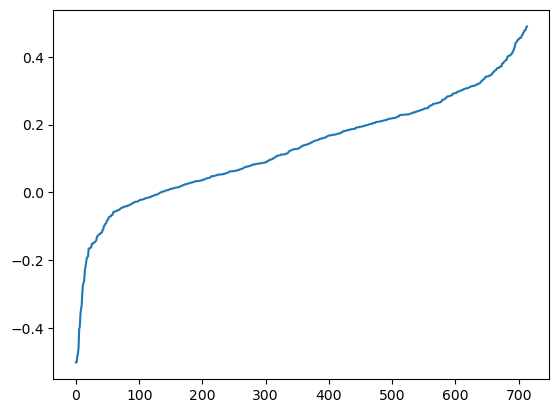

return without cost statistics
mean 0.00298048457864049
std 0.03541090796336758
sharpe 0.08416854438535684
double sharpe 1.09475484882486
max drawdown 19.67848226953919
min -1.1471399681123262
min sharpe 0.0025981873716291307
return with cost statistics
mean 0.0019728480967042624
std 0.03541778421781436
sharpe 0.05570218861156096
double sharpe 0.6750059678327707
max drawdown 20.03773359002443
min -1.147639968136075
min sharpe 0.0017190479170121958


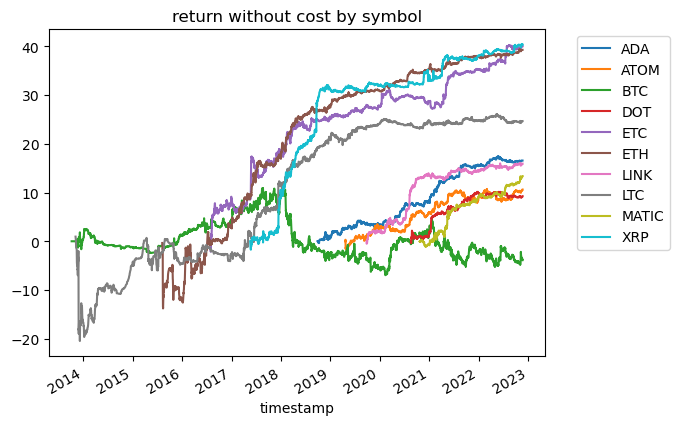

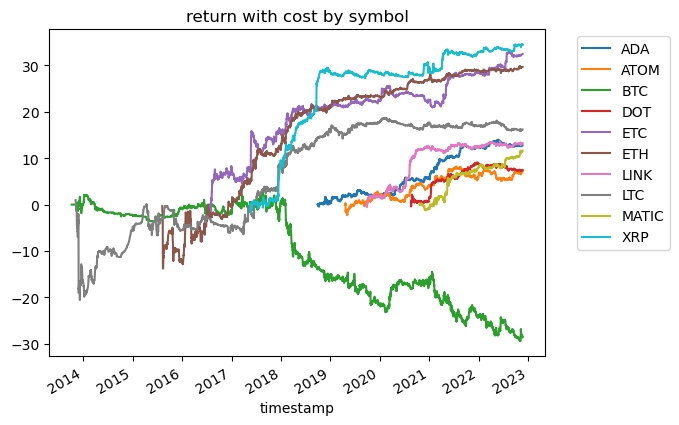

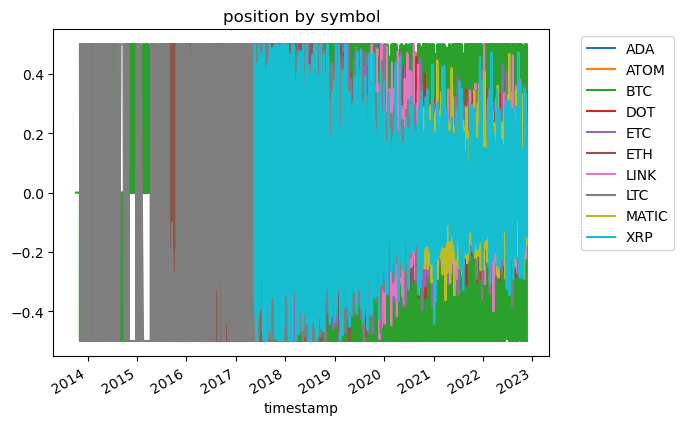

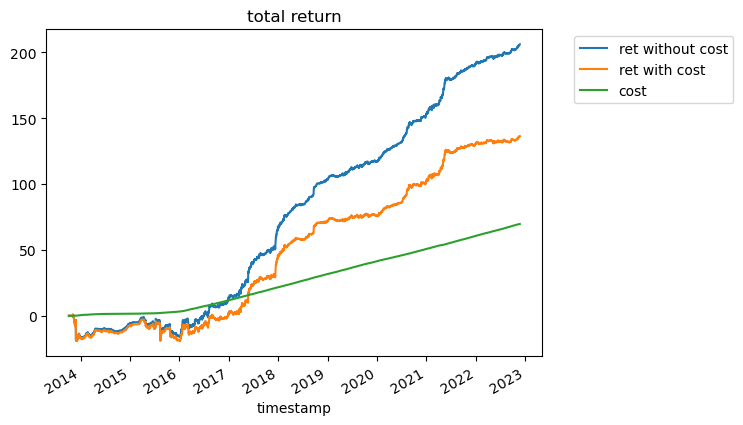

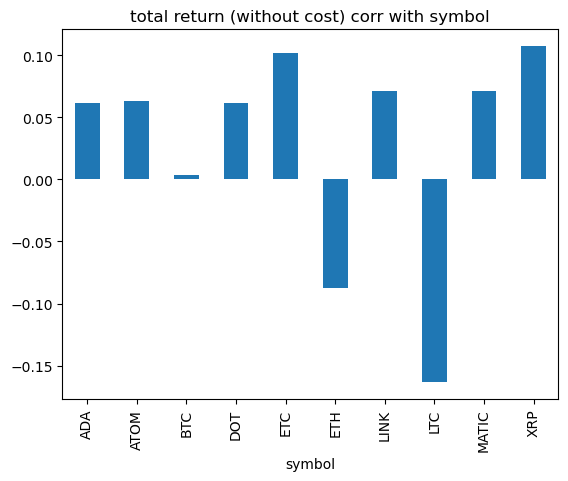

return without cost statistics
mean 0.0029527986123442772
std 0.01753755469226362
sharpe 0.168370030152884
double sharpe 1.1388297697120917
max drawdown 3.8475501303859487
min -0.1590665811038654
min sharpe 0.018563287095585426
return with cost statistics
mean 0.0019257592443653237
std 0.01753563833452328
sharpe 0.10981974009888115
double sharpe 0.6493048389561308
max drawdown 4.733076045675053
min -0.1590665811038654
min sharpe 0.01210662372323112


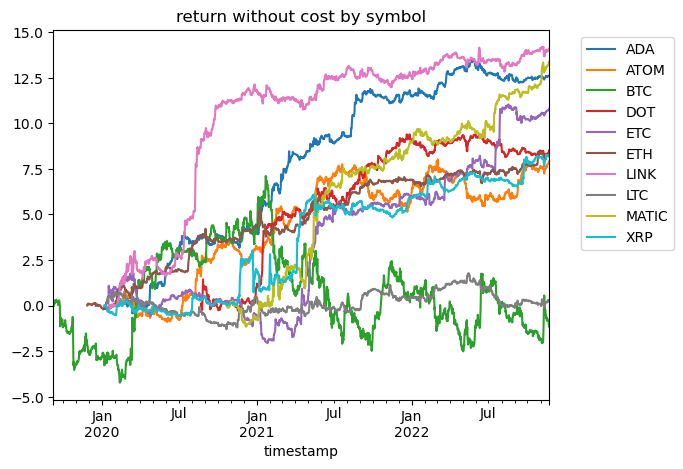

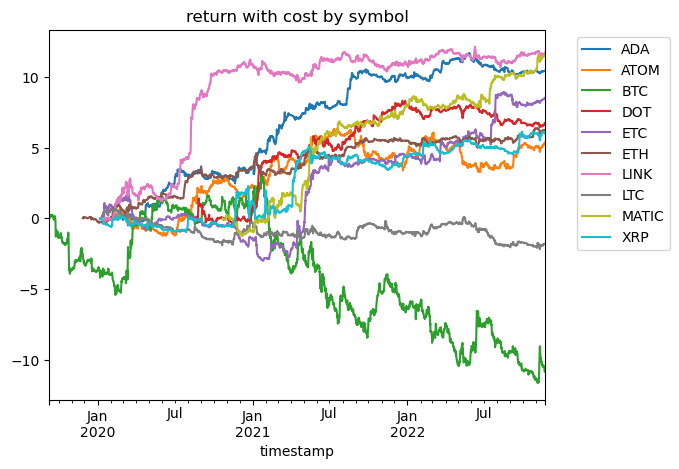

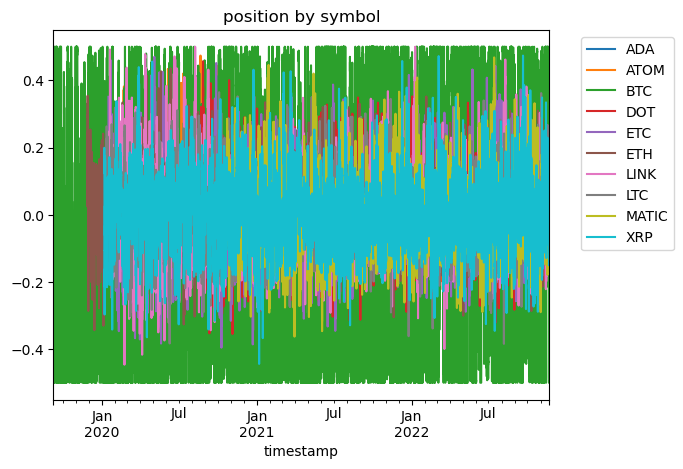

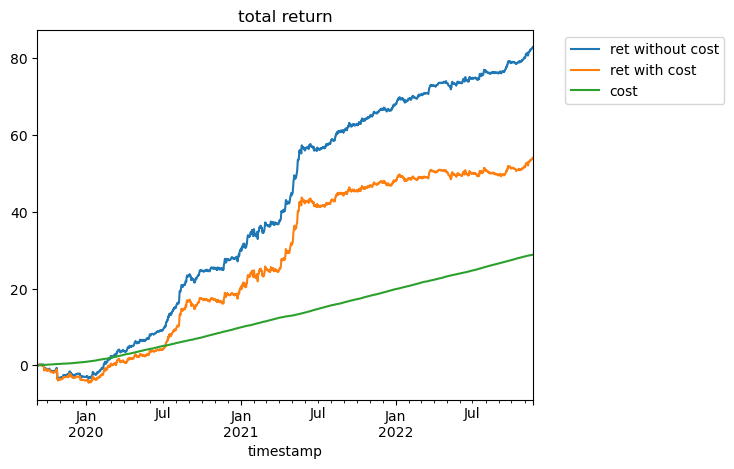

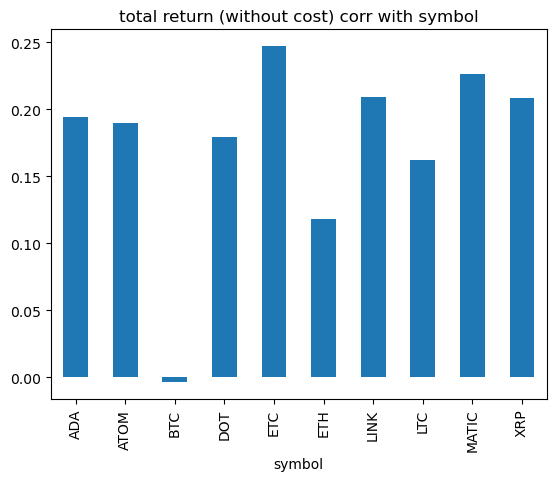

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (351166, 731)
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[

INFO:tensorflow:Assets written to: /tmp/tmp1y8u_gp9/assets
2022-11-22 11:24:16.962691: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:16.962783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:16.963022: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1y8u_gp9
2022-11-22 11:24:16.964957: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:16.964984: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1y8u_gp9
2022-11-22 11:24:16.970387: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:17.034935: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1y8u_gp9
2022-11-22 11:24:17.048466: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpao2x4v5p/assets


INFO:tensorflow:Assets written to: /tmp/tmpao2x4v5p/assets
2022-11-22 11:24:18.444014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:18.444119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:18.444316: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpao2x4v5p
2022-11-22 11:24:18.446135: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:18.446172: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpao2x4v5p
2022-11-22 11:24:18.451680: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:18.516333: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpao2x4v5p
2022-11-22 11:24:18.529245: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwdfh2pgw/assets


INFO:tensorflow:Assets written to: /tmp/tmpwdfh2pgw/assets
2022-11-22 11:24:19.893797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:19.893877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:19.894077: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwdfh2pgw
2022-11-22 11:24:19.895834: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:19.895856: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwdfh2pgw
2022-11-22 11:24:19.903395: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:19.967625: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwdfh2pgw
2022-11-22 11:24:19.980662: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpocbo7xi8/assets


INFO:tensorflow:Assets written to: /tmp/tmpocbo7xi8/assets
2022-11-22 11:24:21.365405: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:21.365491: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:21.365683: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpocbo7xi8
2022-11-22 11:24:21.367454: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:21.367479: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpocbo7xi8
2022-11-22 11:24:21.373034: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:21.441516: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpocbo7xi8
2022-11-22 11:24:21.455166: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf828z6lc/assets


INFO:tensorflow:Assets written to: /tmp/tmpf828z6lc/assets
2022-11-22 11:24:22.832985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:22.833074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:22.833270: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf828z6lc
2022-11-22 11:24:22.835034: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:22.835059: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf828z6lc
2022-11-22 11:24:22.840540: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:22.905427: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf828z6lc
2022-11-22 11:24:22.919329: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9_i9fr7q/assets


INFO:tensorflow:Assets written to: /tmp/tmp9_i9fr7q/assets
2022-11-22 11:24:26.643260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:26.643353: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:26.643557: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9_i9fr7q
2022-11-22 11:24:26.646232: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:26.646279: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9_i9fr7q
2022-11-22 11:24:26.654760: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:26.732541: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9_i9fr7q
2022-11-22 11:24:26.750706: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbmmv_xci/assets


INFO:tensorflow:Assets written to: /tmp/tmpbmmv_xci/assets
2022-11-22 11:24:28.230858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:28.230951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:28.231156: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbmmv_xci
2022-11-22 11:24:28.233421: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:28.233468: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbmmv_xci
2022-11-22 11:24:28.240358: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:28.312662: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbmmv_xci
2022-11-22 11:24:28.327314: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkymq3iyw/assets


INFO:tensorflow:Assets written to: /tmp/tmpkymq3iyw/assets
2022-11-22 11:24:29.732657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:29.732751: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:29.732983: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkymq3iyw
2022-11-22 11:24:29.735000: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:29.735034: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkymq3iyw
2022-11-22 11:24:29.741387: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:29.811198: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkymq3iyw
2022-11-22 11:24:29.827830: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpemkn6ntn/assets


INFO:tensorflow:Assets written to: /tmp/tmpemkn6ntn/assets
2022-11-22 11:24:31.239103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:31.239192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:31.239383: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpemkn6ntn
2022-11-22 11:24:31.241321: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:31.241347: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpemkn6ntn
2022-11-22 11:24:31.247063: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:31.315500: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpemkn6ntn
2022-11-22 11:24:31.329904: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr6nmw74v/assets


INFO:tensorflow:Assets written to: /tmp/tmpr6nmw74v/assets
2022-11-22 11:24:32.734118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:32.734197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:32.734390: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr6nmw74v
2022-11-22 11:24:32.736250: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:32.736277: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr6nmw74v
2022-11-22 11:24:32.741971: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:32.808353: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr6nmw74v
2022-11-22 11:24:32.822180: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpaog603yc/assets


INFO:tensorflow:Assets written to: /tmp/tmpaog603yc/assets
2022-11-22 11:24:34.229397: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:34.229482: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:34.229677: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaog603yc
2022-11-22 11:24:34.231499: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:34.231523: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpaog603yc
2022-11-22 11:24:34.237432: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:34.305619: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpaog603yc
2022-11-22 11:24:34.321397: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpavtgkdph/assets


INFO:tensorflow:Assets written to: /tmp/tmpavtgkdph/assets
2022-11-22 11:24:35.712122: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:35.712213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:35.712406: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpavtgkdph
2022-11-22 11:24:35.714229: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:35.714255: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpavtgkdph
2022-11-22 11:24:35.719606: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:35.786130: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpavtgkdph
2022-11-22 11:24:35.799512: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmns2565t/assets


INFO:tensorflow:Assets written to: /tmp/tmpmns2565t/assets
2022-11-22 11:24:37.199277: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:37.199357: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:37.199549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmns2565t
2022-11-22 11:24:37.201358: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:37.201392: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmns2565t
2022-11-22 11:24:37.206935: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:37.271751: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmns2565t
2022-11-22 11:24:37.285154: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3oumr_30/assets


INFO:tensorflow:Assets written to: /tmp/tmp3oumr_30/assets
2022-11-22 11:24:38.658880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:38.658962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:38.659173: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3oumr_30
2022-11-22 11:24:38.660979: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:38.661003: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3oumr_30
2022-11-22 11:24:38.666417: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:38.728957: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3oumr_30
2022-11-22 11:24:38.741955: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa0fzfdl6/assets


INFO:tensorflow:Assets written to: /tmp/tmpa0fzfdl6/assets
2022-11-22 11:24:40.103158: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:40.103239: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:40.103434: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa0fzfdl6
2022-11-22 11:24:40.105246: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:40.105271: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa0fzfdl6
2022-11-22 11:24:40.110859: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:40.178794: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa0fzfdl6
2022-11-22 11:24:40.195204: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa9lbcz2z/assets


INFO:tensorflow:Assets written to: /tmp/tmpa9lbcz2z/assets
2022-11-22 11:24:41.552055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:41.552142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:41.552336: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa9lbcz2z
2022-11-22 11:24:41.554162: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:41.554190: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa9lbcz2z
2022-11-22 11:24:41.559564: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:41.624547: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa9lbcz2z
2022-11-22 11:24:41.638242: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb8sn5vu1/assets


INFO:tensorflow:Assets written to: /tmp/tmpb8sn5vu1/assets
2022-11-22 11:24:43.028990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:43.029082: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:43.029274: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb8sn5vu1
2022-11-22 11:24:43.031052: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:43.031080: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb8sn5vu1
2022-11-22 11:24:43.036344: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:43.100556: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb8sn5vu1
2022-11-22 11:24:43.114081: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzznxf9um/assets


INFO:tensorflow:Assets written to: /tmp/tmpzznxf9um/assets
2022-11-22 11:24:44.497642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:44.497726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:44.497918: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzznxf9um
2022-11-22 11:24:44.499820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:44.499847: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzznxf9um
2022-11-22 11:24:44.507292: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:44.573325: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzznxf9um
2022-11-22 11:24:44.586814: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa_dyv9w0/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_dyv9w0/assets
2022-11-22 11:24:45.975353: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:45.975439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:45.975642: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa_dyv9w0
2022-11-22 11:24:45.977554: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:45.977582: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa_dyv9w0
2022-11-22 11:24:45.985117: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:46.051043: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa_dyv9w0
2022-11-22 11:24:46.064362: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5rbrxko4/assets


INFO:tensorflow:Assets written to: /tmp/tmp5rbrxko4/assets
2022-11-22 11:24:47.449590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:47.449666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:47.449856: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5rbrxko4
2022-11-22 11:24:47.451739: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:47.451768: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5rbrxko4
2022-11-22 11:24:47.459372: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:47.530567: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5rbrxko4
2022-11-22 11:24:47.543758: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphz1p96dx/assets


INFO:tensorflow:Assets written to: /tmp/tmphz1p96dx/assets
2022-11-22 11:24:48.965811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:48.965904: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:48.966106: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphz1p96dx
2022-11-22 11:24:48.968027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:48.968058: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphz1p96dx
2022-11-22 11:24:48.975698: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:49.045214: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphz1p96dx
2022-11-22 11:24:49.058769: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk07_kzy9/assets


INFO:tensorflow:Assets written to: /tmp/tmpk07_kzy9/assets
2022-11-22 11:24:50.456271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:50.456349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:50.456540: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk07_kzy9
2022-11-22 11:24:50.458455: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:50.458483: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk07_kzy9
2022-11-22 11:24:50.465752: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:50.531175: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk07_kzy9
2022-11-22 11:24:50.544337: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8nkuoi90/assets


INFO:tensorflow:Assets written to: /tmp/tmp8nkuoi90/assets
2022-11-22 11:24:51.922050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:51.922137: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:51.922338: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8nkuoi90
2022-11-22 11:24:51.924224: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:51.924247: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8nkuoi90
2022-11-22 11:24:51.931451: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:51.995375: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8nkuoi90
2022-11-22 11:24:52.007934: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp66b7lx57/assets


INFO:tensorflow:Assets written to: /tmp/tmp66b7lx57/assets
2022-11-22 11:24:53.393517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:53.393603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:53.393792: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp66b7lx57
2022-11-22 11:24:53.395717: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:53.395743: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp66b7lx57
2022-11-22 11:24:53.403179: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:53.468485: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp66b7lx57
2022-11-22 11:24:53.482512: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfwwvqrnj/assets


INFO:tensorflow:Assets written to: /tmp/tmpfwwvqrnj/assets
2022-11-22 11:24:54.904388: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:54.904466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:54.904664: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfwwvqrnj
2022-11-22 11:24:54.906645: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:54.906672: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfwwvqrnj
2022-11-22 11:24:54.914033: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:54.979825: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfwwvqrnj
2022-11-22 11:24:54.993132: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp18cmr6f_/assets


INFO:tensorflow:Assets written to: /tmp/tmp18cmr6f_/assets
2022-11-22 11:24:56.368072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:56.368165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:56.368358: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp18cmr6f_
2022-11-22 11:24:56.370274: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:56.370306: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp18cmr6f_
2022-11-22 11:24:56.377639: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:56.442910: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp18cmr6f_
2022-11-22 11:24:56.456838: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpru425k6s/assets


INFO:tensorflow:Assets written to: /tmp/tmpru425k6s/assets
2022-11-22 11:24:57.809344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:57.809430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:57.809620: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpru425k6s
2022-11-22 11:24:57.811478: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:57.811502: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpru425k6s
2022-11-22 11:24:57.818601: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:57.884102: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpru425k6s
2022-11-22 11:24:57.896947: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgfuz2p4v/assets


INFO:tensorflow:Assets written to: /tmp/tmpgfuz2p4v/assets
2022-11-22 11:24:59.240951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:24:59.241034: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:24:59.241252: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgfuz2p4v
2022-11-22 11:24:59.243124: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:24:59.243156: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgfuz2p4v
2022-11-22 11:24:59.250236: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:24:59.316254: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgfuz2p4v
2022-11-22 11:24:59.329429: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpajohs88_/assets


INFO:tensorflow:Assets written to: /tmp/tmpajohs88_/assets
2022-11-22 11:25:04.344893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:04.344992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:04.345211: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpajohs88_
2022-11-22 11:25:04.348947: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:04.349015: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpajohs88_
2022-11-22 11:25:04.361554: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:04.463673: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpajohs88_
2022-11-22 11:25:04.485039: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2o4q85sc/assets


INFO:tensorflow:Assets written to: /tmp/tmp2o4q85sc/assets
2022-11-22 11:25:05.994887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:05.994980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:05.995175: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2o4q85sc
2022-11-22 11:25:05.997791: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:05.997841: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2o4q85sc
2022-11-22 11:25:06.005710: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:06.080221: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2o4q85sc
2022-11-22 11:25:06.096238: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfpllibi5/assets


INFO:tensorflow:Assets written to: /tmp/tmpfpllibi5/assets
2022-11-22 11:25:07.509943: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:07.510038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:07.510230: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfpllibi5
2022-11-22 11:25:07.512462: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:07.512489: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfpllibi5
2022-11-22 11:25:07.519364: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:07.593211: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfpllibi5
2022-11-22 11:25:07.608128: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4n7prwyr/assets


INFO:tensorflow:Assets written to: /tmp/tmp4n7prwyr/assets
2022-11-22 11:25:09.016463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:09.016539: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:09.016731: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4n7prwyr
2022-11-22 11:25:09.018776: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:09.018803: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4n7prwyr
2022-11-22 11:25:09.025014: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:09.094444: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4n7prwyr
2022-11-22 11:25:09.109342: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2mwkhhcu/assets


INFO:tensorflow:Assets written to: /tmp/tmp2mwkhhcu/assets
2022-11-22 11:25:10.528233: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:10.528319: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:10.528522: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2mwkhhcu
2022-11-22 11:25:10.530610: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:10.530635: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2mwkhhcu
2022-11-22 11:25:10.536926: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:10.610358: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2mwkhhcu
2022-11-22 11:25:10.624475: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6b4d9a4f/assets


INFO:tensorflow:Assets written to: /tmp/tmp6b4d9a4f/assets
2022-11-22 11:25:11.992041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:11.992131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:11.992336: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6b4d9a4f
2022-11-22 11:25:11.994354: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:11.994378: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6b4d9a4f
2022-11-22 11:25:12.000229: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:12.066802: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6b4d9a4f
2022-11-22 11:25:12.080597: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbtw8ry4o/assets


INFO:tensorflow:Assets written to: /tmp/tmpbtw8ry4o/assets
2022-11-22 11:25:13.466721: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:13.466807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:13.466996: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbtw8ry4o
2022-11-22 11:25:13.468907: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:13.468932: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbtw8ry4o
2022-11-22 11:25:13.474620: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:13.541334: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbtw8ry4o
2022-11-22 11:25:13.557249: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpthhg359s/assets


INFO:tensorflow:Assets written to: /tmp/tmpthhg359s/assets
2022-11-22 11:25:14.928913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:14.929005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:14.929204: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpthhg359s
2022-11-22 11:25:14.931129: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:14.931156: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpthhg359s
2022-11-22 11:25:14.937137: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:15.007054: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpthhg359s
2022-11-22 11:25:15.020975: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf5h3yb3t/assets


INFO:tensorflow:Assets written to: /tmp/tmpf5h3yb3t/assets
2022-11-22 11:25:16.406002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:16.406078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:16.406274: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf5h3yb3t
2022-11-22 11:25:16.408156: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:16.408180: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf5h3yb3t
2022-11-22 11:25:16.413804: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:16.483546: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf5h3yb3t
2022-11-22 11:25:16.497406: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbiiph3su/assets


INFO:tensorflow:Assets written to: /tmp/tmpbiiph3su/assets
2022-11-22 11:25:17.892199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:17.892287: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:17.892479: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbiiph3su
2022-11-22 11:25:17.894417: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:17.894445: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbiiph3su
2022-11-22 11:25:17.900231: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:17.966219: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbiiph3su
2022-11-22 11:25:17.979679: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0hvuvyeb/assets


INFO:tensorflow:Assets written to: /tmp/tmp0hvuvyeb/assets
2022-11-22 11:25:19.365623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:19.365713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:19.365909: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0hvuvyeb
2022-11-22 11:25:19.367827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:19.367859: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0hvuvyeb
2022-11-22 11:25:19.373714: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:19.442653: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0hvuvyeb
2022-11-22 11:25:19.456891: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5unsue4_/assets


INFO:tensorflow:Assets written to: /tmp/tmp5unsue4_/assets
2022-11-22 11:25:20.860319: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:20.860411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:20.860604: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5unsue4_
2022-11-22 11:25:20.862530: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:20.862557: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5unsue4_
2022-11-22 11:25:20.868243: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:20.935806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5unsue4_
2022-11-22 11:25:20.949729: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8gcg0nel/assets


INFO:tensorflow:Assets written to: /tmp/tmp8gcg0nel/assets
2022-11-22 11:25:22.318725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:22.318820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:22.319030: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8gcg0nel
2022-11-22 11:25:22.320956: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:22.320993: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8gcg0nel
2022-11-22 11:25:22.326938: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:22.395000: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8gcg0nel
2022-11-22 11:25:22.408906: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqy6g04rq/assets


INFO:tensorflow:Assets written to: /tmp/tmpqy6g04rq/assets
2022-11-22 11:25:23.798160: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:23.798249: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:23.798440: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqy6g04rq
2022-11-22 11:25:23.800316: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:23.800344: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqy6g04rq
2022-11-22 11:25:23.806188: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:23.871927: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqy6g04rq
2022-11-22 11:25:23.885890: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvypgqamt/assets


INFO:tensorflow:Assets written to: /tmp/tmpvypgqamt/assets
2022-11-22 11:25:25.253328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:25.253413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:25.253605: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvypgqamt
2022-11-22 11:25:25.255531: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:25.255566: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvypgqamt
2022-11-22 11:25:25.261199: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:25.329466: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvypgqamt
2022-11-22 11:25:25.343142: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9j0bdwwl/assets


INFO:tensorflow:Assets written to: /tmp/tmp9j0bdwwl/assets
2022-11-22 11:25:26.719606: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:26.719702: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:26.719927: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9j0bdwwl
2022-11-22 11:25:26.722035: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:26.722062: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9j0bdwwl
2022-11-22 11:25:26.727535: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:26.793489: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9j0bdwwl
2022-11-22 11:25:26.808085: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcm3efvr0/assets


INFO:tensorflow:Assets written to: /tmp/tmpcm3efvr0/assets
2022-11-22 11:25:28.180517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:28.180609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:28.180825: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcm3efvr0
2022-11-22 11:25:28.182756: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:28.182784: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcm3efvr0
2022-11-22 11:25:28.188170: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:28.254323: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcm3efvr0
2022-11-22 11:25:28.268760: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5_p_aopb/assets


INFO:tensorflow:Assets written to: /tmp/tmp5_p_aopb/assets
2022-11-22 11:25:29.647461: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:29.647550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:29.647741: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5_p_aopb
2022-11-22 11:25:29.649636: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:29.649663: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5_p_aopb
2022-11-22 11:25:29.655146: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:29.720344: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5_p_aopb
2022-11-22 11:25:29.733848: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfzhby5_g/assets


INFO:tensorflow:Assets written to: /tmp/tmpfzhby5_g/assets
2022-11-22 11:25:34.005368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:34.005458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:34.005654: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfzhby5_g
2022-11-22 11:25:34.008410: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:34.008555: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfzhby5_g
2022-11-22 11:25:34.017944: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:34.103504: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfzhby5_g
2022-11-22 11:25:34.122225: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpaq4dn53u/assets


INFO:tensorflow:Assets written to: /tmp/tmpaq4dn53u/assets
2022-11-22 11:25:35.630062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:35.630167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:35.630368: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaq4dn53u
2022-11-22 11:25:35.632948: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:35.632986: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpaq4dn53u
2022-11-22 11:25:35.641235: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:35.717246: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpaq4dn53u
2022-11-22 11:25:35.736274: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoj_i8q4q/assets


INFO:tensorflow:Assets written to: /tmp/tmpoj_i8q4q/assets
2022-11-22 11:25:37.144025: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:37.144107: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:37.144307: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoj_i8q4q
2022-11-22 11:25:37.146563: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:37.146590: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoj_i8q4q
2022-11-22 11:25:37.153478: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:37.227210: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoj_i8q4q
2022-11-22 11:25:37.242508: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe3p_k2mx/assets


INFO:tensorflow:Assets written to: /tmp/tmpe3p_k2mx/assets
2022-11-22 11:25:38.631817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:38.631904: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:38.632107: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe3p_k2mx
2022-11-22 11:25:38.634364: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:38.634396: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe3p_k2mx
2022-11-22 11:25:38.641411: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:38.711438: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe3p_k2mx
2022-11-22 11:25:38.725753: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvzut6k24/assets


INFO:tensorflow:Assets written to: /tmp/tmpvzut6k24/assets
2022-11-22 11:25:40.134175: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:40.134264: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:40.134457: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvzut6k24
2022-11-22 11:25:40.136589: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:40.136625: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvzut6k24
2022-11-22 11:25:40.143197: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:40.216944: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvzut6k24
2022-11-22 11:25:40.233690: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy9didaga/assets


INFO:tensorflow:Assets written to: /tmp/tmpy9didaga/assets
2022-11-22 11:25:41.637825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:41.637910: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:41.638103: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy9didaga
2022-11-22 11:25:41.640160: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:41.640188: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy9didaga
2022-11-22 11:25:41.646541: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:41.714750: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy9didaga
2022-11-22 11:25:41.728449: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4h4z8s8i/assets


INFO:tensorflow:Assets written to: /tmp/tmp4h4z8s8i/assets
2022-11-22 11:25:43.136710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:43.136833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:43.137036: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4h4z8s8i
2022-11-22 11:25:43.139097: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:43.139139: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4h4z8s8i
2022-11-22 11:25:43.145404: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:43.218454: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4h4z8s8i
2022-11-22 11:25:43.232375: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzla92_bq/assets


INFO:tensorflow:Assets written to: /tmp/tmpzla92_bq/assets
2022-11-22 11:25:44.608221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:44.608320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:44.608534: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzla92_bq
2022-11-22 11:25:44.610587: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:44.610622: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzla92_bq
2022-11-22 11:25:44.617278: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:44.690079: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzla92_bq
2022-11-22 11:25:44.704234: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprvk6yn9l/assets


INFO:tensorflow:Assets written to: /tmp/tmprvk6yn9l/assets
2022-11-22 11:25:46.075727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:46.075816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:46.076011: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprvk6yn9l
2022-11-22 11:25:46.078008: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:46.078035: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprvk6yn9l
2022-11-22 11:25:46.084003: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:46.151000: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprvk6yn9l
2022-11-22 11:25:46.166887: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe1lhx7_1/assets


INFO:tensorflow:Assets written to: /tmp/tmpe1lhx7_1/assets
2022-11-22 11:25:47.556946: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:47.557042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:47.557239: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe1lhx7_1
2022-11-22 11:25:47.559251: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:47.559290: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe1lhx7_1
2022-11-22 11:25:47.565908: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:47.637273: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe1lhx7_1
2022-11-22 11:25:47.651403: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsx_o10yy/assets


INFO:tensorflow:Assets written to: /tmp/tmpsx_o10yy/assets
2022-11-22 11:25:49.050497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:49.050582: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:49.050785: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsx_o10yy
2022-11-22 11:25:49.052758: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:49.052830: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsx_o10yy
2022-11-22 11:25:49.058799: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:49.127411: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsx_o10yy
2022-11-22 11:25:49.142511: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpetqr_r_2/assets


INFO:tensorflow:Assets written to: /tmp/tmpetqr_r_2/assets
2022-11-22 11:25:50.541753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:50.541855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:50.542057: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpetqr_r_2
2022-11-22 11:25:50.544042: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:50.544086: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpetqr_r_2
2022-11-22 11:25:50.550363: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:50.621121: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpetqr_r_2
2022-11-22 11:25:50.636338: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8icopwo1/assets


INFO:tensorflow:Assets written to: /tmp/tmp8icopwo1/assets
2022-11-22 11:25:52.013738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:52.013832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:52.014040: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8icopwo1
2022-11-22 11:25:52.016006: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:52.016047: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8icopwo1
2022-11-22 11:25:52.022149: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:52.091599: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8icopwo1
2022-11-22 11:25:52.105752: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjkrj1fz0/assets


INFO:tensorflow:Assets written to: /tmp/tmpjkrj1fz0/assets
2022-11-22 11:25:53.468696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:53.468814: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:53.469020: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjkrj1fz0
2022-11-22 11:25:53.471271: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:53.471304: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjkrj1fz0
2022-11-22 11:25:53.477452: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:53.544416: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjkrj1fz0
2022-11-22 11:25:53.558603: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjinokxbm/assets


INFO:tensorflow:Assets written to: /tmp/tmpjinokxbm/assets
2022-11-22 11:25:57.315752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:57.315842: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:57.316038: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjinokxbm
2022-11-22 11:25:57.318956: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:57.318994: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjinokxbm
2022-11-22 11:25:57.328530: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:57.410103: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjinokxbm
2022-11-22 11:25:57.428685: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbyazl63n/assets


INFO:tensorflow:Assets written to: /tmp/tmpbyazl63n/assets
2022-11-22 11:25:58.909523: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:25:58.909610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:25:58.909806: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbyazl63n
2022-11-22 11:25:58.912236: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:25:58.912274: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbyazl63n
2022-11-22 11:25:58.920742: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:25:58.999459: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbyazl63n
2022-11-22 11:25:59.016854: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp16ll4rze/assets


INFO:tensorflow:Assets written to: /tmp/tmp16ll4rze/assets
2022-11-22 11:26:00.479811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:00.479906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:00.480113: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp16ll4rze
2022-11-22 11:26:00.482399: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:00.482441: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp16ll4rze
2022-11-22 11:26:00.490099: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:00.567122: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp16ll4rze
2022-11-22 11:26:00.584859: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvzqz6lcd/assets


INFO:tensorflow:Assets written to: /tmp/tmpvzqz6lcd/assets
2022-11-22 11:26:01.994042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:01.994138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:01.994333: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvzqz6lcd
2022-11-22 11:26:01.996358: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:01.996383: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvzqz6lcd
2022-11-22 11:26:02.002916: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:02.075502: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvzqz6lcd
2022-11-22 11:26:02.090801: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnvmvb4vg/assets


INFO:tensorflow:Assets written to: /tmp/tmpnvmvb4vg/assets
2022-11-22 11:26:03.490403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:03.490498: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:03.490700: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnvmvb4vg
2022-11-22 11:26:03.492748: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:03.492834: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnvmvb4vg
2022-11-22 11:26:03.499424: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:03.572241: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnvmvb4vg
2022-11-22 11:26:03.587366: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy54b3x7_/assets


INFO:tensorflow:Assets written to: /tmp/tmpy54b3x7_/assets
2022-11-22 11:26:04.999543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:04.999624: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:04.999815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy54b3x7_
2022-11-22 11:26:05.001826: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:05.001859: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy54b3x7_
2022-11-22 11:26:05.008197: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:05.079993: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy54b3x7_
2022-11-22 11:26:05.094593: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphvrrjdy3/assets


INFO:tensorflow:Assets written to: /tmp/tmphvrrjdy3/assets
2022-11-22 11:26:06.505040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:06.505125: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:06.505319: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphvrrjdy3
2022-11-22 11:26:06.507186: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:06.507211: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphvrrjdy3
2022-11-22 11:26:06.513182: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:06.586902: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphvrrjdy3
2022-11-22 11:26:06.601883: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2vvz4aln/assets


INFO:tensorflow:Assets written to: /tmp/tmp2vvz4aln/assets
2022-11-22 11:26:08.010855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:08.010949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:08.011152: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2vvz4aln
2022-11-22 11:26:08.013094: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:08.013122: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2vvz4aln
2022-11-22 11:26:08.019149: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:08.089276: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2vvz4aln
2022-11-22 11:26:08.103484: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc6f9czph/assets


INFO:tensorflow:Assets written to: /tmp/tmpc6f9czph/assets
2022-11-22 11:26:09.472367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:09.472448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:09.472642: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc6f9czph
2022-11-22 11:26:09.474521: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:09.474548: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc6f9czph
2022-11-22 11:26:09.480603: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:09.552870: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc6f9czph
2022-11-22 11:26:09.567410: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_5qcm9ul/assets


INFO:tensorflow:Assets written to: /tmp/tmp_5qcm9ul/assets
2022-11-22 11:26:10.928911: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:10.929008: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:10.929203: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_5qcm9ul
2022-11-22 11:26:10.931051: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:10.931077: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_5qcm9ul
2022-11-22 11:26:10.937043: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:11.007918: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_5qcm9ul
2022-11-22 11:26:11.022524: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzkpk64ot/assets


INFO:tensorflow:Assets written to: /tmp/tmpzkpk64ot/assets
2022-11-22 11:26:14.109470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:14.109557: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:14.109753: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzkpk64ot
2022-11-22 11:26:14.112604: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:14.112635: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzkpk64ot
2022-11-22 11:26:14.122326: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:14.215508: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzkpk64ot
2022-11-22 11:26:14.233912: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgucsgbg0/assets


INFO:tensorflow:Assets written to: /tmp/tmpgucsgbg0/assets
2022-11-22 11:26:15.712448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:15.712537: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:15.712732: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgucsgbg0
2022-11-22 11:26:15.715305: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:15.715350: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgucsgbg0
2022-11-22 11:26:15.723239: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:15.803452: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgucsgbg0
2022-11-22 11:26:15.822510: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe__j9wn5/assets


INFO:tensorflow:Assets written to: /tmp/tmpe__j9wn5/assets
2022-11-22 11:26:17.254407: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:17.254500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:17.254696: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe__j9wn5
2022-11-22 11:26:17.257029: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:17.257057: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe__j9wn5
2022-11-22 11:26:17.264196: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:17.336089: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe__j9wn5
2022-11-22 11:26:17.352676: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbd3u_cs1/assets


INFO:tensorflow:Assets written to: /tmp/tmpbd3u_cs1/assets
2022-11-22 11:26:18.787503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:18.787587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:18.787777: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbd3u_cs1
2022-11-22 11:26:18.789955: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:18.789982: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbd3u_cs1
2022-11-22 11:26:18.796508: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:18.865646: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbd3u_cs1
2022-11-22 11:26:18.879816: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpta4axgwo/assets


INFO:tensorflow:Assets written to: /tmp/tmpta4axgwo/assets
2022-11-22 11:26:20.253539: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:20.253628: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:20.253817: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpta4axgwo
2022-11-22 11:26:20.255980: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:20.256017: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpta4axgwo
2022-11-22 11:26:20.262636: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:20.334952: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpta4axgwo
2022-11-22 11:26:20.349439: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6cbskqci/assets


INFO:tensorflow:Assets written to: /tmp/tmp6cbskqci/assets
2022-11-22 11:26:21.732303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:21.732389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:21.732586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6cbskqci
2022-11-22 11:26:21.734703: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:21.734736: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6cbskqci
2022-11-22 11:26:21.740980: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:21.811255: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6cbskqci
2022-11-22 11:26:21.826252: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfskzgbb3/assets


INFO:tensorflow:Assets written to: /tmp/tmpfskzgbb3/assets
2022-11-22 11:26:23.215610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:23.215705: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:23.215901: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfskzgbb3
2022-11-22 11:26:23.218034: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:23.218071: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfskzgbb3
2022-11-22 11:26:23.225253: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:23.296525: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfskzgbb3
2022-11-22 11:26:23.311183: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyhohp393/assets


INFO:tensorflow:Assets written to: /tmp/tmpyhohp393/assets
2022-11-22 11:26:24.682636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:24.682727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:24.682921: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyhohp393
2022-11-22 11:26:24.685011: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:24.685056: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyhohp393
2022-11-22 11:26:24.691390: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:24.761517: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyhohp393
2022-11-22 11:26:24.776658: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplcokhnqz/assets


INFO:tensorflow:Assets written to: /tmp/tmplcokhnqz/assets
2022-11-22 11:26:27.578128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:27.578230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:27.578429: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplcokhnqz
2022-11-22 11:26:27.581167: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:27.581196: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplcokhnqz
2022-11-22 11:26:27.590892: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:27.672034: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplcokhnqz
2022-11-22 11:26:27.692454: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8taefgrs/assets


INFO:tensorflow:Assets written to: /tmp/tmp8taefgrs/assets
2022-11-22 11:26:29.161187: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 11:26:29.161276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 11:26:29.161468: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8taefgrs
2022-11-22 11:26:29.163854: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 11:26:29.163901: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8taefgrs
2022-11-22 11:26:29.172233: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 11:26:29.252934: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8taefgrs
2022-11-22 11:26:29.268799: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [16]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- 

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


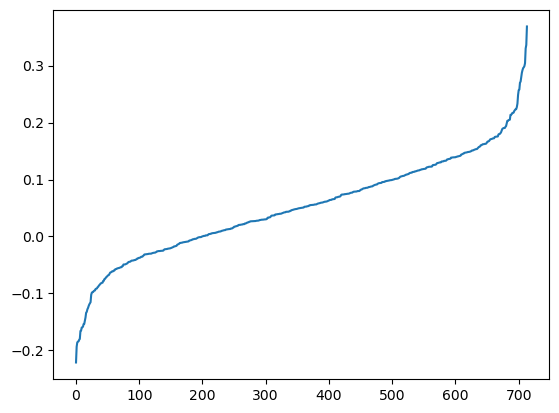

timestamp                  symbol
2022-09-23 06:00:00+00:00  ADA      -0.056513
                           ATOM     -0.055042
                           BTC       0.500000
                           DOT      -0.057046
                           ETC      -0.056558
                                       ...   
2022-11-22 06:00:00+00:00  ETH       0.144344
                           LINK     -0.100788
                           LTC       0.061680
                           MATIC    -0.107171
                           XRP      -0.191764
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


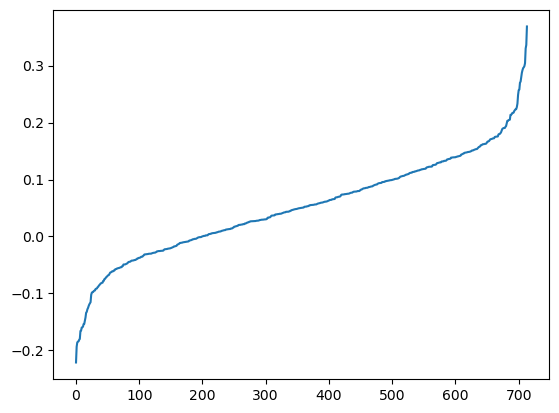

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


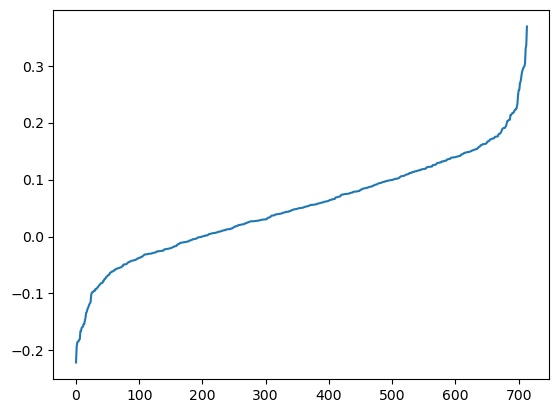

/tmp/ipykernel_12/724680936.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/724680936.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


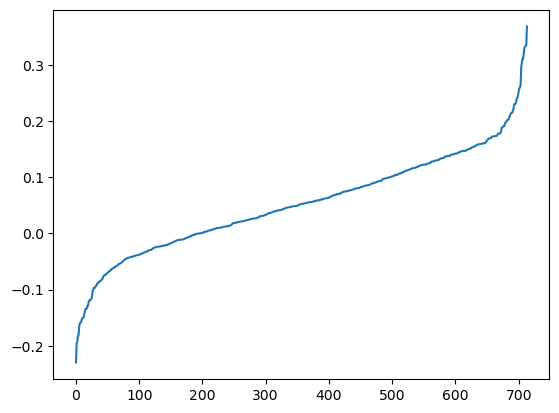

position1  position2  position3
timestamp                 symbol                                 
2022-09-23 07:00:00+00:00 ADA      0.056871   0.056871  -0.055481
                          ATOM     0.047127   0.047127  -0.056545
                          BTC     -0.500000  -0.500000   0.500000
                          DOT      0.056297   0.056297  -0.055437
                          ETC      0.056912   0.056912  -0.055306
...                                     ...        ...        ...
2022-11-22 05:00:00+00:00 ETH      0.044951   0.044951   0.045005
                          LINK    -0.073000  -0.073000  -0.073319
                          LTC      0.147949   0.147949   0.146941
                          MATIC   -0.101920  -0.101920  -0.100165
                          XRP     -0.203827  -0.203827  -0.204717

[14390 rows x 3 columns]

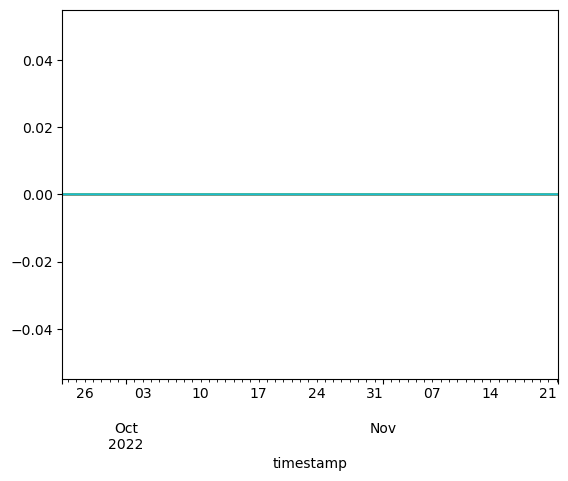

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


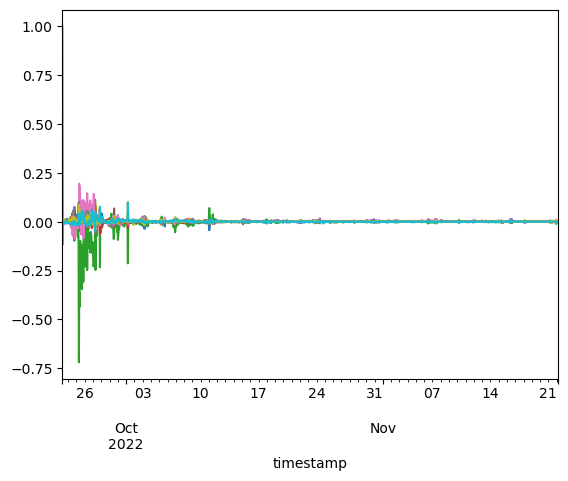

In [17]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

In [18]:
# https://arxiv.org/pdf/1902.06853.pdf

def eoc_v(f, sigma_w=1.0):
    def v(x):
        n = 10000
        z = np.random.normal(0, 1, n)
        return sigma_w ** 2 * np.mean(f(x ** 0.5 * z) ** 2)
    return v

def eoc_sigma_w(f, f_deriva, sigma_b=0.0):
    f_v = eoc_v(f)
    f_deriva_v = eoc_v(f_deriva)
    q = 0
    for i in range(100):
        q = sigma_b ** 2 + f_v(q) / f_deriva_v(q)
    return 1.0 / f_deriva_v(q) ** 0.5

# def gelu(x):
    
# def gelu_deriva(x):
    
    